In [1]:
from keras.models import load_model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing import image
import keras.backend as K
from keras import activations

from vis.utils import utils
# from vis.visualization import visualize_saliency

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import os, random
from google_images_download import google_images_download
    

Using TensorFlow backend.


In [2]:
IMG_SIZE = 224
img_shape = (IMG_SIZE, IMG_SIZE, 3)

model = VGG16()


### grad cam with softmax first

In [3]:

def load_img(img_dir):
    '''
    load one image into one numpy array after preprocessing for xception
    '''
    img_img = image.load_img(img_dir, target_size = (IMG_SIZE, IMG_SIZE))
    img = image.img_to_array(img_img)
    img_processed = preprocess_input(img)

    return img_processed


In [4]:
test_img_dir = '/Users/yueying.teng/Documents/indoor_gps/visualization/dog_for_gradcam.jpg'
dog = load_img(test_img_dir)
preds = model.predict(dog[np.newaxis,: ])
top_six_preds = np.argsort(-preds[0])[: 6]
top_six_preds


array([266, 265, 153, 194, 203, 202])

In [5]:
# get corresponding class names
text = open('/Users/yueying.teng/Downloads/imagenet_labels.txt', 'r')
lines = text.readlines()

class_names = []
for i in range(len(lines)):
    class_names.append(lines[i].split(':')[1].split(', ')[0])

top_six_preds_labels = [class_names[i] for i in top_six_preds]


In [6]:
# download images from google keep the downloading directories in one list

response = google_images_download.googleimagesdownload()
top_six_preds_img = []

for i in range(len(top_six_preds_labels)):
    if i == 0:
        top_six_preds_img.append(test_img_dir)
        
    else:
        absolute_image_paths = response.download({"keywords": top_six_preds_labels[i], "limit": 1,
                                                  "no_directory": True,
                                                 "output_directory": '/Users/yueying.teng/Documents/indoor_gps/visualization/vgg_gradcam_img'})

        top_six_preds_img.append(list(absolute_image_paths.values())[0][0])
    


Item no.: 1 --> Item name =  'toy poodle'
Evaluating...
Starting Download...
Completed Image ====> 1. poodle-1.jpg

Errors: 0


Item no.: 2 --> Item name = 

Evaluating...
Starting Download...

Errors: 0


Item no.: 1 --> Item name =  'Maltese dog
Evaluating...
Starting Download...
Completed Image ====> 1. maltese_puppy.jpeg

Errors: 0


Item no.: 1 --> Item name =  'Dandie Dinmont
Evaluating...
Starting Download...
Completed Image ====> 1. dandie-dinmont-terrier-slide-6.jpg

Errors: 0


Item no.: 1 --> Item name =  'West Highland white terrier'
Evaluating...
Starting Download...
Completed Image ====> 1. west-highland-white-terrier-on-white-03.jpg

Errors: 0


Item no.: 2 --> Item name = 

Evaluating...
Starting Download...

Errors: 0


Item no.: 1 --> Item name =  'soft-coated wheaten terrier'
Evaluating...
Starting Download...
Completed Image ====> 1. soft-coated-wheaten-terrier.jpg

Errors: 0


Item no.: 2 --> Item name = 

Evaluating...
Starting Download...

Errors: 0



In [7]:
for i in zip(top_six_preds_labels, top_six_preds_img):
    print (i)

(" 'miniature poodle',\n", '/Users/yueying.teng/Documents/indoor_gps/visualization/dog_for_gradcam.jpg')
(" 'toy poodle',\n", '/Users/yueying.teng/Documents/indoor_gps/visualization/vgg_gradcam_img/1. poodle-1.jpg')
(" 'Maltese dog", '/Users/yueying.teng/Documents/indoor_gps/visualization/vgg_gradcam_img/1. maltese_puppy.jpeg')
(" 'Dandie Dinmont", '/Users/yueying.teng/Documents/indoor_gps/visualization/vgg_gradcam_img/1. dandie-dinmont-terrier-slide-6.jpg')
(" 'West Highland white terrier',\n", '/Users/yueying.teng/Documents/indoor_gps/visualization/vgg_gradcam_img/1. west-highland-white-terrier-on-white-03.jpg')
(" 'soft-coated wheaten terrier',\n", '/Users/yueying.teng/Documents/indoor_gps/visualization/vgg_gradcam_img/1. soft-coated-wheaten-terrier.jpg')


In [8]:

def get_grad_cam(model, class_idx, img_processed, img_path):
    class_output = model.output[:, class_idx]
    last_conv_layer = model.get_layer("block5_conv3")

    # gradients, gradient of the class score w.r.t pixel values in all feature map 
    grads = K.gradients(class_output, last_conv_layer.output)[0]
    # weights, global pooling average of the calcualted gradients from each feature map
    pooled_grads = K.mean(grads, axis = (0, 1, 2))
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

    pooled_grads_value, conv_layer_output_value = iterate([img_processed[np.newaxis, :]])

    # feature maps are weighted using the weights calculated in pooled_grads
    for i in range(conv_layer_output_value.shape[-1]):
        conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    # average the weighted feature maps through all channels 
    heatmap = np.mean(conv_layer_output_value, axis = -1)
    heatmap = np.maximum(heatmap, 0)
    ######################### check the result from normalizing the heatmap ############################
    heatmap /= np.max(heatmap)
#     heatmap = heatmap - np.min(heatmap)
#     heatmap = heatmap / np.max(heatmap)

    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_RAINBOW)
    gradcam_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    return(gradcam_img)


In [9]:
grid = []
for i in range(2):
    for j in range(3):
        grid.append([i, j])


In [22]:
def plot_grad_cam(model, top_six_preds, top_six_preds_img, top_six_preds_class_name):
    fig, ax = plt.subplots(2, 3, figsize = (25, 15)) 

    for idx, pair in enumerate(grid):
        # plot grad cam for the input testing image
        if idx == 0:
            grad_cam = get_grad_cam(model, top_six_preds[idx], load_img(top_six_preds_img[idx]), top_six_preds_img[idx])
            ax[pair[0], pair[1]].imshow(grad_cam)
            ax[pair[0], pair[1]].set_title('input testing image grad cam, class_{}'.format(top_six_preds_class_name[idx]))

        else:
            grad_cam = get_grad_cam(model, top_six_preds[idx], load_img(top_six_preds_img[idx]), top_six_preds_img[idx])
            ax[pair[0], pair[1]].imshow(grad_cam)
            ax[pair[0], pair[1]].set_title('grad cam from top six predictions, class_{}'.format(top_six_preds_class_name[idx]))


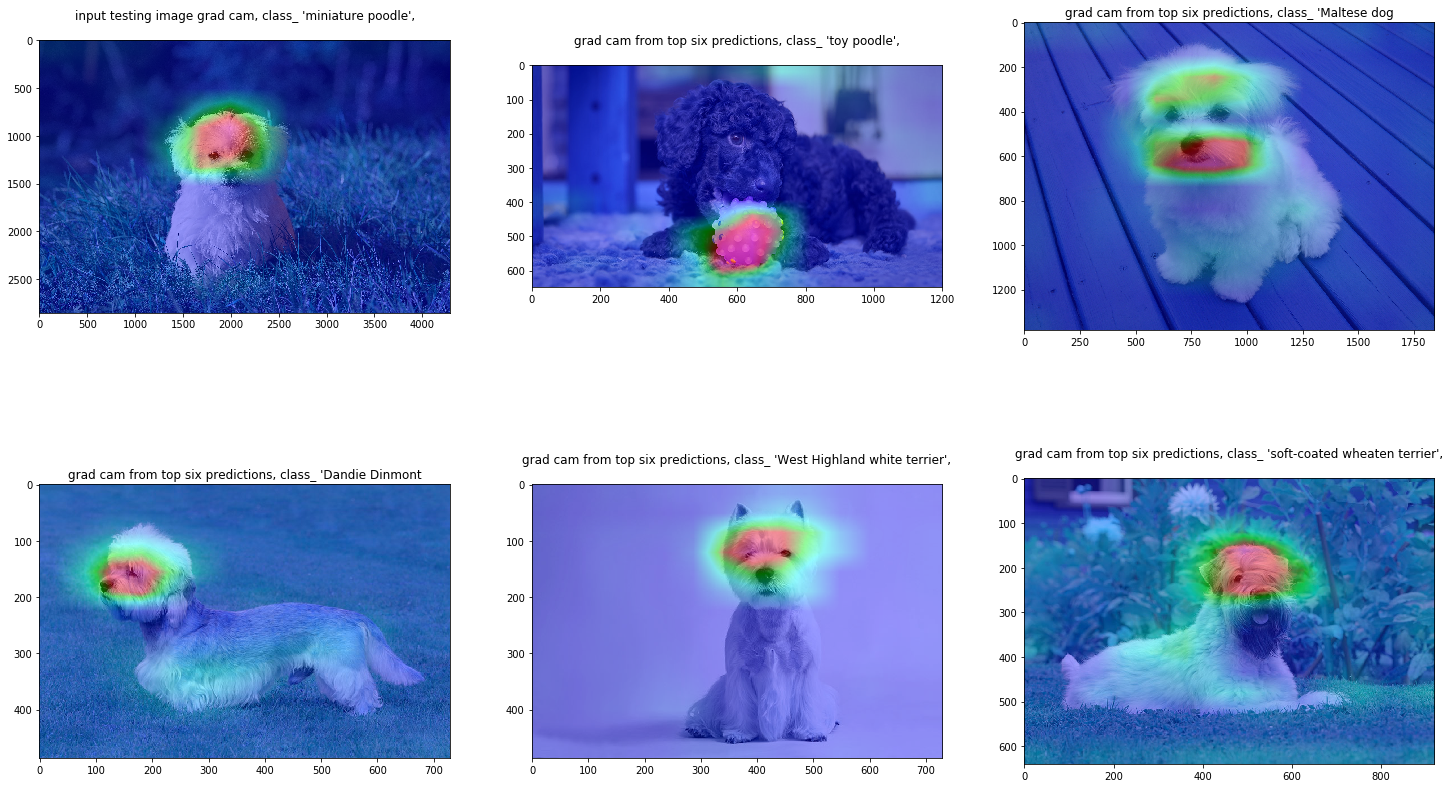

In [23]:

plot_grad_cam(model, top_six_preds, top_six_preds_img, top_six_preds_labels)


### replace softmax with linar activation and redo grad cam plots

In [24]:

# Utility to search for layer index by name.
layer_idx = utils.find_layer_idx(model, 'predictions')

# Swap softmax with a linear activation, f(x) = x for all
model.layers[layer_idx].activation = activations.linear
repalced_model = utils.apply_modifications(model)


/Users/yueying.teng/miniconda3/lib/python3.6/site-packages/keras/models.py:282: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [25]:
dog = load_img(test_img_dir)
preds = model.predict(dog[np.newaxis,: ])
top_six_preds = np.argsort(-preds[0])[: 6]
top_six_preds


array([266, 265, 153, 194, 203, 202])

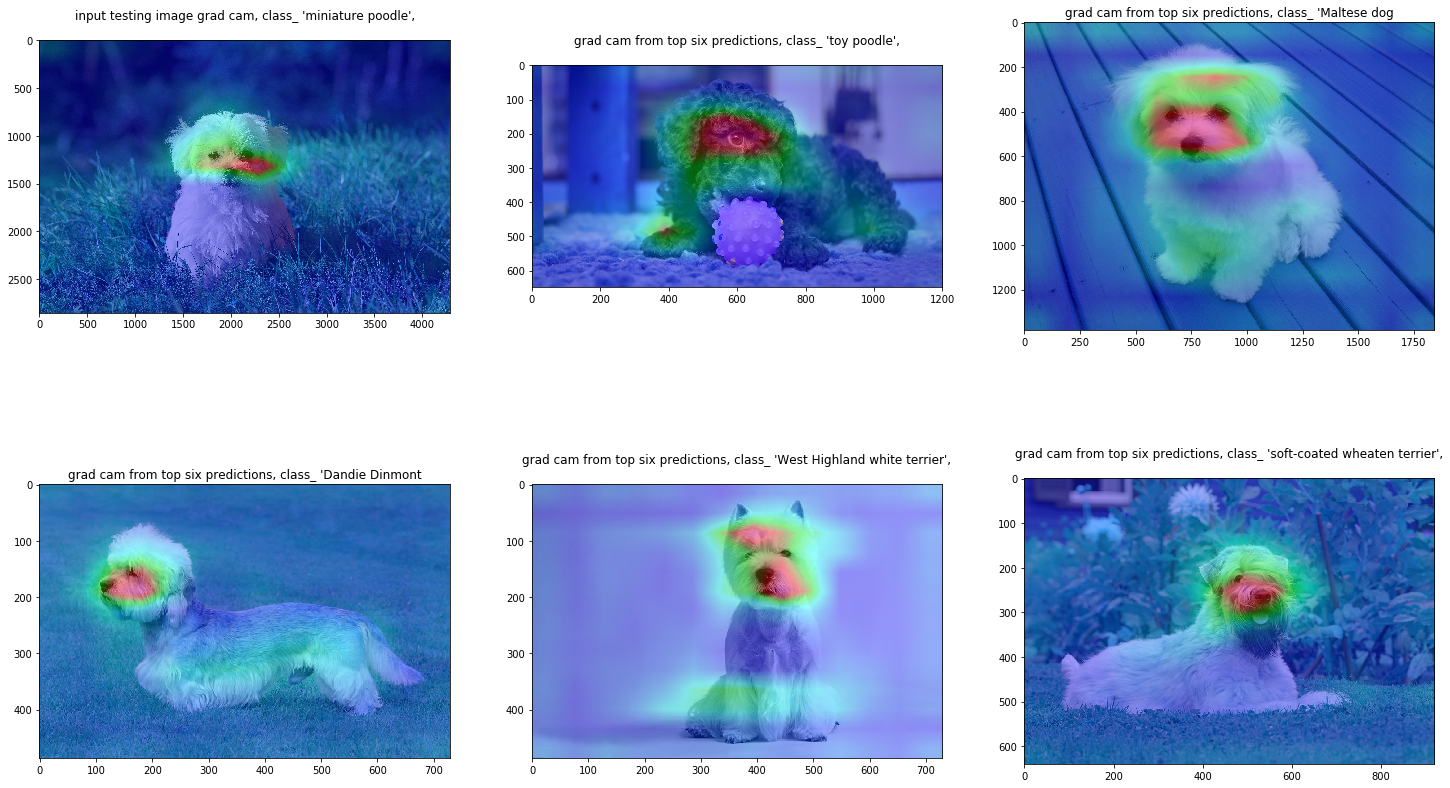

In [26]:

plot_grad_cam(repalced_model, top_six_preds, top_six_preds_img, top_six_preds_labels)


#### replacing softmax with linear activation gives better visualization

see the second most confident prediction - toy_poodle

in vgg16, replacing softmax with linear activation does not change the predicition probabilities
